# Mushroom Classification EDA and Preprocessing


In [20]:
# Import necessary libraries
import pandas as pd # Data manipulation and analysis.
import numpy as np # Numerical operations and array handling.
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt # More control, lower-level, basic plotting.
import seaborn as sns # Higher-level, more aesthetically pleasing plots.
from scipy import stats # Statistical functions and tests.

pd.set_option('display.max_columns', None) # Display all columns in DataFrame output.
pd.set_option('display.max_rows', None) # Display all rows in DataFrame output.

print("Libraries imported done.")

Libraries imported done.


In [3]:
# Load mushroom dataset.
df_ = pd.read_csv('data/mushrooms.csv')

In [4]:
df_.head() # Display the first few rows of the DataFrame to understand its structure and contents.

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [40]:
# Data Overview
# Run the desciribe function to get a summary of the dataset. For example, the total count of features, samples, and the distribution of the poisonous and edible mushrooms. (e- for edible, p- for poisonous)
print("DATASET BASIC INFORMATION")


print(f"Features: {df_.shape[1]-1}")  # -1 for target variable
print(f"Samples: {df_.shape[0]}")


print("\nTarget Variable Distribution:")
print(df_['class'].value_counts())

DATASET BASIC INFORMATION
Features: 22
Samples: 8124

Target Variable Distribution:
class
e    4208
p    3916
Name: count, dtype: int64


# Data Preprocessing
# 1. Handle Duplicates and clean empty rows

After successfully loading the dataset, I will proceed with data preprocessing including handling duplicates, irrelevant data, missing values, and outliers.


In [9]:
# Make a copy to preserve original data
df_clean = df_.copy()

# 1. Handle Duplicates and clean empty rows
empty_rows = df_clean.isnull().all(axis=1).sum()
print(f" Empty rows found: {empty_rows}")

initial_size = len(df_clean)
df_clean = df_clean.drop_duplicates()
removed_duplicates = initial_size - len(df_clean)
print(f" Duplicate rows removed: {removed_duplicates}")

 Empty rows found: 0
 Duplicate rows removed: 0


# 2. Handle Missing Data
Look at the result of duplicates and empty rows handling, there's no empty and duplicates rows.
Then proceed to handle missing data.

In [18]:

# After looking at the dataset, I found that the missing values are fillied by '?'.
# but '?' would not be treated as null in Pandas, so I need to replace '?' with NaN first.

# replace '?' with NaN
df_clean.replace('?', np.nan, inplace=True)
missing_info = df_clean.isnull().sum()
missing_percent = (missing_info / len(df_clean)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_info,
    'Missing Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("Missing Data Result:")
missing_df.head()

# Based on the missing data result, the 'stalk-root' column has 2480 missing values, which is about 30% of the total data.
# Use the most frequent 'stalk-root' category (mode) to fill missing values
mode_val = df_clean['stalk-root'].mode()[0]
df_clean.fillna({'stalk-root': mode_val}, inplace=True)
print(f"Filled missing 'stalk-root' values with mode: {mode_val}")

# Verify that there are no more missing values
print("Missing values after handling:", df_clean.isnull().sum())


Missing Data Result:
Filled missing 'stalk-root' values with mode: b
Missing values after handling: class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


# 3. Handle Irrelevant Data

In [23]:
# Continue to process irrelevant data

# 3.1 Find the columns with only one unique value
constant_cols = [col for col in df_clean.columns if df_clean[col].nunique() == 1]
print(constant_cols)

[]


In [24]:
# 'veil-type' is the only column with one unique value, it contributes nothing to the classification result, so I will drop it.
if constant_cols:
    df_clean = df_clean.drop(columns=constant_cols)


# conduct a chi-square test to see if any other columns are irrelevant to the target variable
contingency = pd.crosstab(df_clean['odor'], df_clean['class'])

# 3.2 Perform the chi-square test.
target = "class"
features = [col for col in df_clean.columns if col != target]

results = []
for col in features:
    contingency = pd.crosstab(df_clean[col], df_clean[target])
    chi2, p, dof, expected = chi2_contingency(contingency)
    results.append((col, chi2, p))

# 3. Sort by p-value
chi_results = pd.DataFrame(results, columns=["Feature","Chi2","p_value"])
chi_results = chi_results.sort_values(by="p_value")

print(chi_results)

                     Feature         Chi2        p_value
20                   habitat  1573.777261   0.000000e+00
18         spore-print-color  4602.033170   0.000000e+00
17                 ring-type  2956.619278   0.000000e+00
3                    bruises  2041.415647   0.000000e+00
4                       odor  7659.726740   0.000000e+00
14    stalk-color-below-ring  2152.390891   0.000000e+00
13    stalk-color-above-ring  2237.898496   0.000000e+00
7                  gill-size  2366.834257   0.000000e+00
8                 gill-color  3765.714086   0.000000e+00
12  stalk-surface-below-ring  2684.474076   0.000000e+00
19                population  1929.740891   0.000000e+00
11  stalk-surface-above-ring  2808.286287   0.000000e+00
10                stalk-root  1059.124136  2.684968e-229
6               gill-spacing   984.143333  5.022978e-216
0                  cap-shape   489.919954  1.196457e-103
16               ring-number   374.736831   4.235758e-82
2                  cap-color   

# 4. Handle Outliers

By looking at the sample code that uses the IQR method(designed for numeric data) to identify outliers. This method may not be suitable for my mushroom dataset (all categorical).

Therefore, I'll use a frequency-based method to identify outliers in categorical data. This method identifies categories that appear very infrequently in the dataset, which may indicate potential outliers.


In [ ]:
# only keep the sample code here for reference.

# IQR (Interquartile Range): Remove points outside Q1 - 1.5*IQR or Q3 + 1.5*IQR

# def find_outliers_IQR_method(input_df, variable):
#     IQR= input_df[variable].quantile(0.75) - input_df[variable].quantile(0.25)
#
#     lower_limit = input_df[variable].quantile(0.25) - (IQR*1.5)
#     upper_limit = input_df[variable].quantile(0.75) + (IQR*1.5)
#
#     return lower_limit, upper_limit

In [27]:
def detect_frequency_outliers(df, rare_threshold=0.5):
    """
    Detect samples with unusually rare category values
    rare_threshold: percentage threshold to consider a category as rare (e.g. 0.5 means <0.5%)
    """

    frequency_outliers = []

    print(f"Identifying samples with rare category values (< {rare_threshold}%):")

    for col in df.columns:
        if col != 'class' and df[col].dtype == 'object':
            # Calculate value frequencies
            value_counts = df[col].value_counts()
            value_percentages = (value_counts / len(df)) * 100

            # Find rare values
            rare_values = value_percentages[value_percentages < rare_threshold]

            if not rare_values.empty:
                print(f"\n {col} - Rare values:")
                for value, percentage in rare_values.items():
                    count = value_counts[value]
                    print(f"   • '{value}': {count} samples ({percentage:.2f}%)")

                    # Find samples with this rare value
                    rare_samples = df[df[col] == value].index.tolist()

                    frequency_outliers.append({
                        'feature': col,
                        'rare_value': value,
                        'count': count,
                        'percentage': percentage,
                        'sample_indices': rare_samples,
                        'reason': f'Extremely rare {col} value: only {percentage:.2f}% of samples'
                    })
            else:
                print(f"{col}: No rare values found")

    return frequency_outliers

print("\nDetecting frequency-based outliers in categorical features...")
frequency_outliers = detect_frequency_outliers(df_clean, rare_threshold=0.5)


Detecting frequency-based outliers in categorical features...
Identifying samples with rare category values (< 0.5%):

 cap-shape - Rare values:
   • 's': 32 samples (0.39%)
   • 'c': 4 samples (0.05%)

 cap-surface - Rare values:
   • 'g': 4 samples (0.05%)

 cap-color - Rare values:
   • 'u': 16 samples (0.20%)
   • 'r': 16 samples (0.20%)
bruises: No rare values found

 odor - Rare values:
   • 'm': 36 samples (0.44%)
gill-attachment: No rare values found
gill-spacing: No rare values found
gill-size: No rare values found

 gill-color - Rare values:
   • 'r': 24 samples (0.30%)
stalk-shape: No rare values found
stalk-root: No rare values found

 stalk-surface-above-ring - Rare values:
   • 'y': 24 samples (0.30%)
stalk-surface-below-ring: No rare values found

 stalk-color-above-ring - Rare values:
   • 'c': 36 samples (0.44%)
   • 'y': 8 samples (0.10%)

 stalk-color-below-ring - Rare values:
   • 'c': 36 samples (0.44%)
   • 'y': 24 samples (0.30%)

 veil-color - Rare values:
   •

# Exploratory Data Analysis (EDA)


In [28]:
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns
categorical_columns = df_clean.select_dtypes(include=['object', 'category']).columns
print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)

Numerical columns: Index([], dtype='object')
Categorical columns: Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat'],
      dtype='object')


### No numerical columns in this dataset, even I can map the categorical data to numerical data, but it may not make sense for the analysis. Therefore I will analyse categorical data instead by chi-square.

## Bar Plot for class distribution

<Axes: xlabel='class', ylabel='count'>

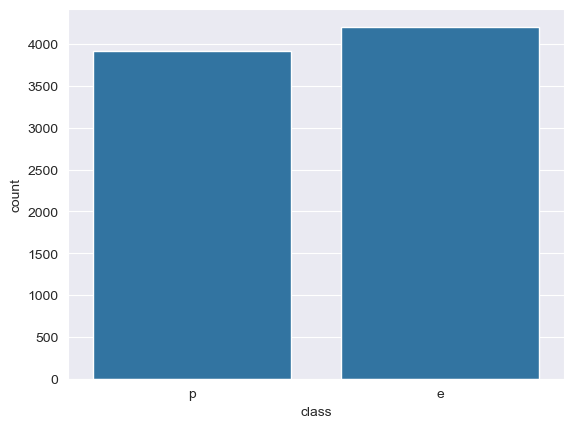

In [29]:
# Count balance of target variable (class, edible or poisonous)
sns.countplot(x='class', data=df_clean)

## Chi-Square Test for feature importance

replacement for Correlation Bar Plot

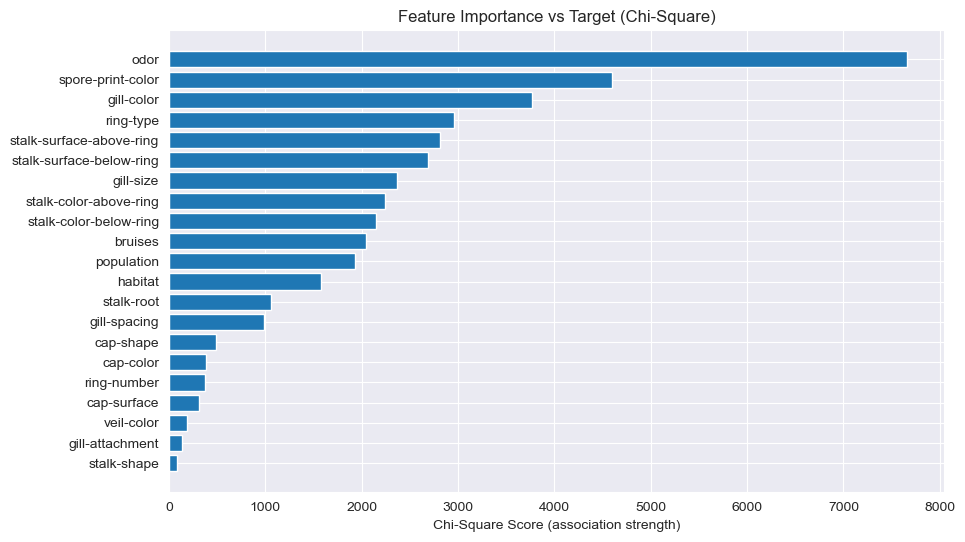

In [33]:
target = "class"
features = [col for col in df_clean.columns if col != target]

results = []
for col in features:
    contingency = pd.crosstab(df_clean[col], df_clean[target])
    chi2, p, dof, expected = chi2_contingency(contingency)
    results.append((col, chi2))

chi_scores = pd.DataFrame(results, columns=["Feature","Chi2"]).sort_values("Chi2", ascending=False)

# Bar plot
plt.figure(figsize=(10,6))
plt.barh(chi_scores["Feature"], chi_scores["Chi2"])
plt.xlabel("Chi-Square Score (association strength)")
plt.title("Feature Importance vs Target (Chi-Square)")
plt.gca().invert_yaxis()
plt.show()

## Pair Plot
skipped - sns.pairplot is typically used for numerical data.


## Heatmap

Visualise the relationship between categorical features and the target variable using a heatmap.

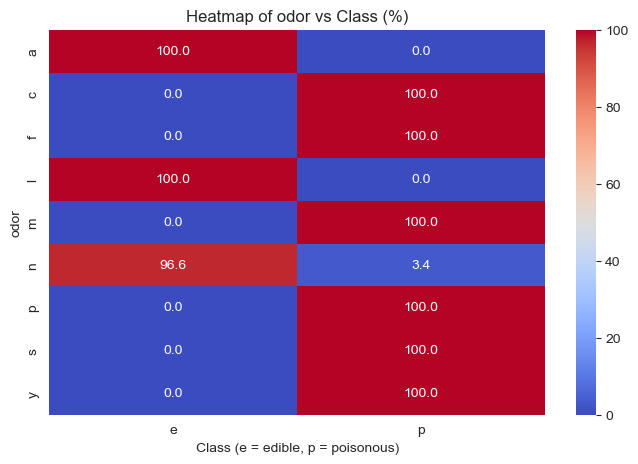

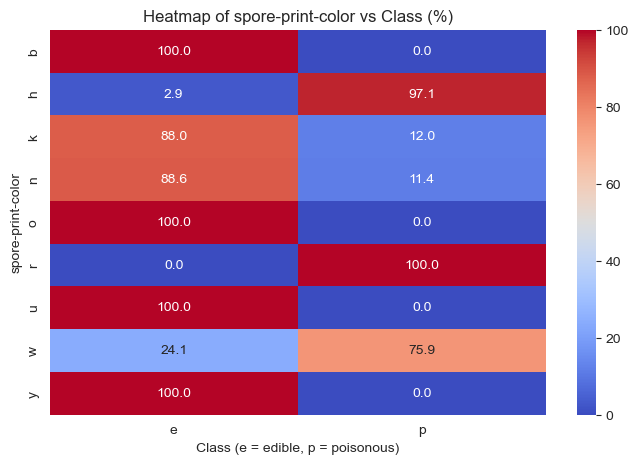

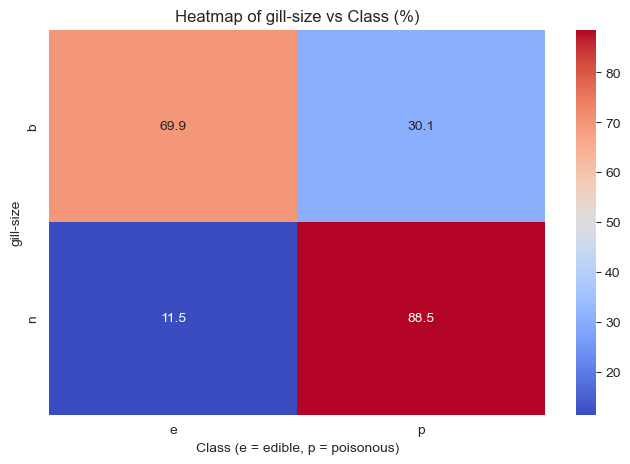

In [39]:
def feature_vs_class(feature):
    ct = pd.crosstab(df_clean[feature], df_clean['class'], normalize='index') * 100
    plt.figure(figsize=(8,5))
    sns.heatmap(ct, annot=True, cmap="coolwarm", fmt=".1f")
    plt.title(f"Heatmap of {feature} vs Class (%)")
    plt.ylabel(f"{feature}")
    plt.xlabel("Class (e = edible, p = poisonous)")
    plt.show()


# 3. Run for odor, spore-print-color, gill-size
for col in ['odor', 'spore-print-color', 'gill-size']:
    feature_vs_class(col)

## Insights
1. The dataset is nearly balanced, containing 4208 edible and 3916 poisonous samples.
2. `odor`, `spore-print-color`, `gill-size` are the most relevant features to identify whether a mushroom is edible or poisonous.
3. Mushrooms with strong smell are highly poisonous. Supported by feature `odor`
    * mushrooms with odors a (almond), l (anise), n (none) → 96–100% edible.
    * f (foul), y (fishy), p (pungent), s (spicy), m (musty), c (creosote) → 100% poisonous.
4. Mushrooms with white spore print color are mostly edible. Supported by feature `spore-print-color`
    * w (white) → 92% edible.
    * b (brown), h (chocolate), k (black), n (green), o (orange), r (red), u (purple) → 100% poisonous.
5. Mushrooms with broad gills are mostly edible. Supported by feature `gill-size`
    * b (broad) → 92% edible.
    * n (narrow) → 100% poisonous.

In [ ]:
# KDE Plot - Kernel Density Estimation
# skipped - KDE is typically used for continuous numerical data. Since the mushroom dataset is categorical, this plot may not be very meaningful here.

# sns.set_theme(style='whitegrid')
# plt.figure(figsize=(20, 8))
#
# sns.kdeplot(data=df, x='FLOOR_AREA', y='PRICE', cmap='Blues', fill=True, levels=10)
# plt.title('KDE Plot of Floor Area vs Price')
# plt.xlabel('Floor Area')
# plt.ylabel('Price')
# plt.show()

In [ ]:
# Histogram
# skipped - histogram is typically used for numerical data.